In [1]:
RANDOM_SEED = 42

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
BENIGN_LABEL = 0
ANOMALY_LABEL = 1

In [4]:
train_stage_1_3_OCSVM = pd.read_csv("data/train_stage_1_3_OCSVM.csv")

X_train = train_stage_1_3_OCSVM.drop(columns=["Label", "Unnamed: 0"])
y_train = np.ones(len(train_stage_1_3_OCSVM["Label"])) * BENIGN_LABEL

del train_stage_1_3_OCSVM

In [5]:
X_train.shape

(10000, 66)

In [6]:
validation_stage_1_3 = pd.read_csv("data/validation_stage_1_3.csv")

X_val = validation_stage_1_3.drop(columns=["Label", "Unnamed: 0"])
y_val = np.where(validation_stage_1_3["Label"] == "BENIGN", BENIGN_LABEL, ANOMALY_LABEL)
print(X_val.shape)
del validation_stage_1_3

(136305, 66)


In [7]:
# Optimized pipelines
f = open("Repositório_Base/models/stage1_ocsvm.p","rb")
stage1 = pickle.load(f)
f.close()

stage1.fit(X_train)

d:\Disciplinas\intrusao\Projeto\Sistema_Hierarquico\Deteccao_de_Intrusao_Hierarquica_Multiestagio\env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.1.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Disciplinas\intrusao\Projeto\Sistema_Hierarquico\Deteccao_de_Intrusao_Hierarquica_Multiestagio\env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Disciplinas\intrusao\Projeto\Sistema_Hierarqu

[LibSVM]

Pipeline(steps=[('scaler',
                 QuantileTransformer(output_distribution='normal',
                                     subsample=100000)),
                ('pca', PCA(n_components=56, random_state=42)),
                ('ocsvm',
                 OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151,
                             verbose=True))])

In [8]:
y_pred_train = stage1.predict(X_train) #marcando 1 como benigno
np.unique(y_pred_train, return_counts=True)

(array([-1,  1], dtype=int64), array([1564, 8436], dtype=int64))

In [9]:
y_score_train = stage1.score_samples(X_train)
y_score_train.min(),y_score_train.max()

(0.004271980092957298, 0.0076173422304803146)

In [10]:
y_pred = stage1.predict(X_val)
y_score = stage1.score_samples(X_val)

In [11]:
# normaliza para ficar entre 0 e 1 como uma probabilidade
y_score = (y_score - y_score.min())/(y_score.max() -y_score.min())

# como valoores maiores sao de benignos, precisamos inverter
y_score = 1-y_score

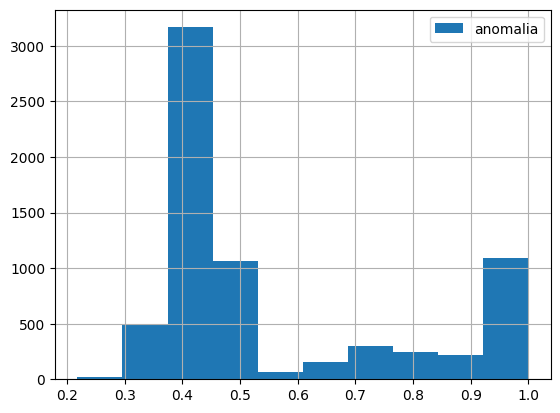

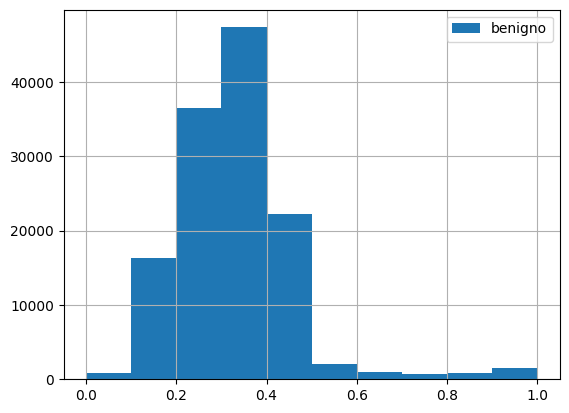

0.0 1.0
0.21778778688723166 0.9999999999945034


In [12]:
y_score_benigno  = pd.Series(y_score[y_val == BENIGN_LABEL])
y_score_anomalia = pd.Series(y_score[y_val == ANOMALY_LABEL])


y_score_anomalia.hist(label= "anomalia")
plt.legend()
plt.show()

y_score_benigno.hist(label= "benigno")
plt.legend()
plt.show()

print(y_score_benigno.min(),y_score_benigno.max())
print(y_score_anomalia.min(),y_score_anomalia.max())


In [13]:
y_pred_ = np.where(y_pred== 1, BENIGN_LABEL, ANOMALY_LABEL)
print(classification_report(y_val, y_pred_))
print(roc_auc_score(y_val, y_score))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89    129485
           1       0.17      0.72      0.27      6820

    accuracy                           0.80    136305
   macro avg       0.57      0.76      0.58    136305
weighted avg       0.94      0.80      0.86    136305

0.8725828057621003


In [14]:
print(classification_report(y_val, np.where(y_score > .25, 1, 0)))

              precision    recall  f1-score   support

           0       1.00      0.26      0.41    129485
           1       0.07      1.00      0.12      6820

    accuracy                           0.30    136305
   macro avg       0.53      0.63      0.27    136305
weighted avg       0.95      0.30      0.40    136305



In [15]:
with open('Models\FirstStage.p', 'wb') as primeiro_estagio_file:
    pickle.dump(stage1, primeiro_estagio_file)